# U-Net - A standard DL image segmentation model
This implements U-NET model to test the proposed model against

U-Net could (and should) be modified to produce a weight matrix for normalised cuts (so the learnt function is within a complex U-net structure, rather than a simple 4-way connection comparison in say brightness weight function)



Also, https://arxiv.org/abs/1711.08506, this paper implements fully unsupervised image segmentation utilising normalised cuts. However, this paper implements a *soft* Ncut loss which is differentiable. By utilising a declarative node a fully Ncuts optimisation could be fully implemented, and made to be differentiable with implifict function thoerem. A potential avenue!

Reference: https://arxiv.org/abs/1505.04597


In [7]:
import torch
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=False, out_sz=(572,572)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

In [8]:
# SETTINGS
batch_size = 16
epochs =10
lr = 0.01

img_size = (100,100)

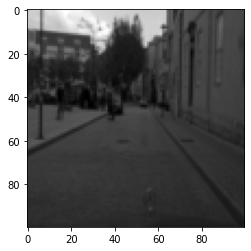

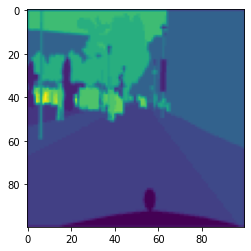

Dataset : 2975 EA 
DataLoader : 186 SET


In [14]:
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

data_transform = transforms.Compose([
    transforms.Resize(size=(100,100)),
    transforms.Grayscale(1),
    transforms.ToTensor()
    ])

target_transform = transforms.Compose([
    transforms.Resize(size=(100,100)),
    transforms.ToTensor()
    ])
    
train_dataset = torchvision.datasets.Cityscapes(root='./data/cityscapes/', split='train', mode='fine',
                     target_type='semantic', transform=data_transform, target_transform=target_transform)

# visualise
img, smnt = train_dataset[0]
plt.imshow(img[0], cmap='gray')
plt.show()
plt.imshow(smnt[0])
plt.show()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print('Dataset : %d EA \nDataLoader : %d SET' % (len(train_dataset),len(train_loader)))

model = UNet(num_class=5, out_sz=img_size)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
step_losses = []
epoch_losses = []
for epoch in tqdm(range(epochs)):
    epoch_loss = 0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))